# Text Analysis


In [2]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


# Part 1: Text Classification

## 1. Import libraries
In this assignment, we are going to use two different statistical models for text classification. Those are Logistic Regression, Naive Bayes, Support Vector Machine, and RandmForest. 
The packages to reach this objective are the following:

In [161]:
%matplotlib inline

from nltk.corpus import stopwords
from nltk import word_tokenize    
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB,BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
#from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from random import sample
import seaborn as sns
import matplotlib.pyplot as plt
#!pip3 install gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from nltk.stem import PorterStemmer # Stem
#!pip install pyLDAvis==2.1.2
import pyLDAvis.gensim
from nltk.corpus import stopwords
import logging
from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2. Import data
The data used in this assignment was gathered from the popular academic website arXiv.org for articles tagged as
computer science content (though some of these are in mathematics or physics categories).

### 2.1 Train data
The documents written between 1990 and 2014

In [57]:
df_train = pd.read_csv("/content/drive/My Drive/Assig1-FIT5212/axcs_train.csv")
df_train.head(3)

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract
0,cs-9301111,arxiv.org/abs/cs/9301111,1989-12-31,Nested satisfiability,0,0,0,Nested satisfiability A special case of the s...
1,cs-9301112,arxiv.org/abs/cs/9301112,1990-03-31,A note on digitized angles,0,0,0,A note on digitized angles We study the confi...
2,cs-9301113,arxiv.org/abs/cs/9301113,1991-07-31,Textbook examples of recursion,0,0,0,Textbook examples of recursion We discuss pro...


### 2.2 Test data
The documents written between 2015 and 2016

In [58]:
df_test = pd.read_csv("/content/drive/My Drive/Assig1-FIT5212/axcs_test.csv")
df_test.head(3)

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract
0,no-150100335,arxiv.org/abs/1501.00335,2015-01-01,A Data Transparency Framework for Mobile Appli...,0.0,0.0,0.0,A Data Transparency Framework for Mobile Appl...
1,no-14024178,arxiv.org/abs/1402.4178,2015-01-01,A reclaimer scheduling problem arising in coal...,0.0,0.0,0.0,A reclaimer scheduling problem arising in coa...
2,no-150100263,arxiv.org/abs/1501.00263,2015-01-01,Communication-Efficient Distributed Optimizati...,0.0,0.0,1.0,Communication-Efficient Distributed Optimizat...


## 3. Create Documents and Labels
A document has three different classes are InfoTheory, CompVis and Math. These can occur in any combination, so an
article could be all three at once, two, one or none. The job is to build text classifiers that predict each of these three classes individually using the Abstract field. That is why we drop the other columns that are useless for this assignment.

### 3.1 Data Wrangling
Before we create the documents and the labels (lists) we have to identify that all the values are valid: No NULL, NA or NaN in the datasets.

From the training dataset no value was removed

In [59]:
print('Number of training papers before removing NaN values: {:,}\n'.format(df_train.shape[0]))
df_train.dropna(axis=0, inplace=True)
print('Number of training papers after removing NaN values: {:,}\n'.format(df_train.shape[0]))

Number of training papers before removing NaN values: 54,731

Number of training papers after removing NaN values: 54,731



From the testing dataset one record was removed. The one corresponding to the document **no-160308961**

In [60]:
df_test[df_test.isnull().any(axis=1)]

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract
19619,no-160308961,arxiv.org/abs/1603.08961,2016-03-29,Betting and Belief: Prediction Markets and Att...,NaN,NaN,NaN,NaN


In [61]:
print('Number of testing papers before removing NaN values: {:,}\n'.format(df_test.shape[0]))
df_test.dropna(axis=0, inplace=True) # Removing NaN values
print('Number of testing papers after removing NaN values: {:,}\n'.format(df_test.shape[0]))

Number of testing papers before removing NaN values: 19,679

Number of testing papers after removing NaN values: 19,678



From the preview of the test data, we could observe that the labels are `float` and not `int`. Therefore, we proceed to transform them

In [62]:
df_test[['Math', 'CompVis', 'InfoTheory']] = np.array(df_test[['Math', 'CompVis', 'InfoTheory']], dtype=int)
df_test.head(3)

,ID,URL,Date,Title,InfoTheory,CompVis,Math,Abstract
0,no-150100335,arxiv.org/abs/1501.00335,2015-01-01,A Data Transparency Framework for Mobile Appli...,0,0,0,A Data Transparency Framework for Mobile Appl...
1,no-14024178,arxiv.org/abs/1402.4178,2015-01-01,A reclaimer scheduling problem arising in coal...,0,0,0,A reclaimer scheduling problem arising in coa...
2,no-150100263,arxiv.org/abs/1501.00263,2015-01-01,Communication-Efficient Distributed Optimizati...,0,0,1,Communication-Efficient Distributed Optimizat...


### 3.2 Documents
The variables `trainDocs` and `testDocs` are lists which each element is an abstract of a different paper

In [63]:
trainDocs = df_train.Abstract.tolist() # Store the abstracts of training as an element of a list
testDocs = df_test.Abstract.tolist() # Store the abstracts of training as an element of a list

### 3.3 Labels
We created six different variables for three different labels of two different dataframes. Two list for `InfoTheory` label, two for `CompVis`, and another two for `Math`. 

In [64]:
trainLabelInfo = np.asarray(df_train.InfoTheory.to_list()) # Train dataset InfoTheory
trainLabelComp = np.asarray(df_train.CompVis.to_list()) # Train dataset CompVis
trainLabelMath = np.asarray(df_train.Math.to_list()) # Train dataset Math
testLabelInfo = np.asarray(df_test.InfoTheory.to_list()) # Test dataset InfoTheory
testLabelComp = np.asarray(df_test.CompVis.to_list()) # Test dataset CompVis
testLabelMath = np.asarray(df_test.Math.to_list()) # Test dataset Math

## 4. Text Preprocessing
One of the main tasks of the assignment is to compare how two different preprocessing methods perform in a model and understand if there is any tokenization method in particular that could improve the performance of a model. 

That is why in order to get the same preprocessing method for each model `RNN` and `LinearSVC` we are going to build a new csv file with the abstracts already tokenized. 

The reason why we do that instead of tokenizing them with the **vectorizer** function in LinearSVC and **spaCy** in RNN model. Is that we can not set the same parameters in both cases, and it could be that by using these preprocessing methods we get different results. Therefore, have 4 different preprocessing results instead of 2 as it was required in the assignment.


Before apply different method first we convert al tokens to lower case as it is required for different preprofcessing methods


In [65]:
train_abstracts1 = [] # List to store the train abstracts with preprocessing method #1
test_abstracts1 = [] # List to store the test abstracts with preprocessing method #1
train_abstracts2 = [] # List to store the train abstracts with preprocessing method #2
test_abstracts2 = [] # List to store the test abstracts with preprocessing method #2

for idx in range(len(trainDocs)):
    train_abstracts1.append(trainDocs[idx].lower())  # Convert to lowercase.
    train_abstracts2.append(trainDocs[idx].lower())  # Convert to lowercase.

for idx in range(len(testDocs)):
    test_abstracts1.append(testDocs[idx].lower())  # Convert to lowercase.  
    test_abstracts2.append(testDocs[idx].lower())  # Convert to lowercase. 

After converting every word to lower in each list, we proceed to preprocess them in two different ways as we did before

### 4.1. Preprocessing #1
   - Convert every word to lower case
   - Tokenize each words with the following regex: `r'\w+'`
   - Remove numbers
   - Remove english stop words
   - Remove words with length equal 1
   - Stem every words of the corpus

In [66]:
# Tokenize every document of the dataset
tokenizer = RegexpTokenizer(r'\w+') # Tokenizer that matches every element of the corpus

for idx in range(len(train_abstracts1)):
    train_abstracts1[idx] = tokenizer.tokenize(train_abstracts1[idx])  # Split into words.

for idx in range(len(test_abstracts1)):
    test_abstracts1[idx] = tokenizer.tokenize(test_abstracts1[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
train_abstracts1 = [[token for token in doc if not token.isnumeric()] for doc in train_abstracts1]
test_abstracts1 = [[token for token in doc if not token.isnumeric()] for doc in test_abstracts1]

# Remove numbers, but not words that contain numbers.
stop_words = set(stopwords.words('english')) 
train_abstracts1 = [[token for token in doc if not token in stop_words] for doc in train_abstracts1]
test_abstracts1 = [[token for token in doc if not token in stop_words] for doc in test_abstracts1]

# Remove words that are only one character.
train_abstracts1 = [[token for token in doc if len(token) > 1] for doc in train_abstracts1]
test_abstracts1 = [[token for token in doc if len(token) > 1] for doc in test_abstracts1]

# Steeming of all the tokens
stemmer = PorterStemmer() # Porter Stemmer
train_abstracts1 = [['{1}'.format(token, stemmer.stem(token)) for token in doc] for doc in train_abstracts1]
test_abstracts1 = [['{1}'.format(token, stemmer.stem(token)) for token in doc] for doc in test_abstracts1]

### 4.2 Preprocessing #2
   - Convert every word to lower case
   - Tokenize each words with the following regex: `r'[a-z0-9]+'`
   - Remove words with length equal 1
   - Lematize every words of the corpus
   - Create bigrams that appear at least 100 times in the corpus

In [67]:
# Tokenize every document of the dataset
tokenizer = RegexpTokenizer(r'[a-z0-9]+') # Tokenizer that matches every element of the corpus

for idx in range(len(train_abstracts2)):
    train_abstracts2[idx] = tokenizer.tokenize(train_abstracts2[idx])  # Split into words.

for idx in range(len(test_abstracts2)):
    test_abstracts2[idx] = tokenizer.tokenize(test_abstracts2[idx])  # Split into words.


# Remove words that are only one character.
train_abstracts2 = [[token for token in doc if len(token) > 1] for doc in train_abstracts2]
test_abstracts2 = [[token for token in doc if len(token) > 1] for doc in test_abstracts2]

# Lemmatize the documents.
lemmatizer = WordNetLemmatizer()
train_abstracts2 = [[lemmatizer.lemmatize(token) for token in doc] for doc in train_abstracts2]
test_abstracts2 = [[lemmatizer.lemmatize(token) for token in doc] for doc in test_abstracts2]

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
train_bigram = Phrases(train_abstracts2, min_count=100)
test_bigram = Phrases(test_abstracts2, min_count=100)

for idx in range(len(train_abstracts2)):
    for token in train_bigram[train_abstracts2[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            train_abstracts2[idx].append(token)

for idx in range(len(test_abstracts2)):
    for token in test_bigram[test_abstracts2[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            test_abstracts2[idx].append(token)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


### 4.3 Comparison between Preprocesing Methods
After performing the tokenization with two different method we can observe the words that are in one corpus but not in the other one. In this comparisson it is pretty clear the difference between Stemming and Lemmatization with words like:
   - claus vs. clause
   - assum vs. assuming
   - conveni vs. convenient

Also we can observe that one method has bigrams and the other no, therefore we see words in `train_abstracts2` that we do not see in `train_abstracts1` like:
   - have_been
   - special_case


In [68]:
np.setdiff1d(train_abstracts1[0], train_abstracts2[0])

array(['assum', 'claus', 'conveni', 'hierarch', 'nest', 'repres',
       'satisfi', 'solvabl', 'structur'], dtype='<U8')

In [69]:
np.setdiff1d(train_abstracts2[0], train_abstracts1[0])

array(['assuming', 'be', 'been', 'clause', 'convenient', 'have',
       'have_been', 'hierarchical', 'in', 'is', 'nested', 'of',
       'represented', 'satisfiability', 'solvable', 'special_case',
       'structure', 'that', 'the', 'to', 'which'], dtype='<U14')

### 4.4 Export Tokenization
After we create the tokens of each abstract with the same parameters shown before, we create different dataframes with all the information required to perform the `RNN` adn the `LinearSVC` model. That is why we build an csv file with the abstracts preprocessed as shown before

In [70]:
# Convert tokens to strings again
train_abstracts1 = [" ".join(tokens) for tokens in train_abstracts1]
train_abstracts2 = [" ".join(tokens) for tokens in train_abstracts2]
test_abstracts1 = [" ".join(tokens) for tokens in test_abstracts1]
test_abstracts2 = [" ".join(tokens) for tokens in test_abstracts2]

After converting the tokens to string again, we store the information in different dataframes to export them later as csv file

**Train Dataset with Preprocessing Method #1**

In [71]:
df_train_prep_1 = pd.DataFrame(list(zip(trainLabelInfo, trainLabelComp, 
                                        trainLabelMath, train_abstracts1)),
                   columns=['InfoTheory', 'CompVis', 'Math','Abstract'])

df_train_prep_1[:2]

,InfoTheory,CompVis,Math,Abstract
0,0,0,0,nest satisfi special case satisfi problem clau...
1,0,0,0,note digit angl studi configur pixel occur two...


**Train Dataset with Preprocessing Method #2**

In [72]:
df_train_prep_2 = pd.DataFrame(list(zip(trainLabelInfo, trainLabelComp, 
                                        trainLabelMath, train_abstracts2)),
                   columns=['InfoTheory', 'CompVis', 'Math','Abstract'])

df_train_prep_2[:2]

,InfoTheory,CompVis,Math,Abstract
0,0,0,0,nested satisfiability special case of the sati...
1,0,0,0,note on digitized angle we study the configura...


**Test Dataset with Preprocessing Method #1**

In [73]:
df_test_prep_1 = pd.DataFrame(list(zip(testLabelInfo, testLabelComp, 
                                        testLabelMath, test_abstracts1)),
                   columns=['InfoTheory', 'CompVis', 'Math','Abstract'])

df_test_prep_1[:2]

,InfoTheory,CompVis,Math,Abstract
0,0,0,0,data transpar framework mobil applic today mob...
1,0,0,0,reclaim schedul problem aris coal stockyard ma...


**Test Dataset with Preprocessing Method #1**

In [74]:
df_test_prep_2 = pd.DataFrame(list(zip(testLabelInfo, testLabelComp, 
                                        testLabelMath, test_abstracts2)),
                   columns=['InfoTheory', 'CompVis', 'Math','Abstract'])

df_test_prep_2[:2]

,InfoTheory,CompVis,Math,Abstract
0,0,0,0,data transparency framework for mobile applica...
1,0,0,0,reclaimer scheduling problem arising in coal s...


After we build these dataframes we export them to a csv file to read it, with the RNN algorithm and Linear SVC. 

The reason why we have 6 different dataframes is because we have one dataframe for each combination of preprocessing method, and size of dataset for train dataset. Besides we have two different preprocessing methods for testing dataset 

In [75]:
df_train_prep_1.to_csv("./train_prep_1.csv", index=False)
df_test_prep_1.to_csv("./test_prep_1.csv", index=False)
df_train_prep_2.to_csv("./train_prep_2.csv", index=False)
df_test_prep_2.to_csv("./test_prep_2.csv", index=False)
df_train_prep_1[:1000].to_csv("./train_prep_1_1000.csv", index=False)
df_train_prep_2[:1000].to_csv("./train_prep_2_1000.csv", index=False)

## 5. Statistical Model
After perform the preprocessing method, we proceed to perform the classification of abstracts in three different labels: `InfoTheory`, `CompVis` and `Math`

### 5.1 Vectorizers
After create new documents the only tokenizer that we need is split the words by space. 
Therefore, we create four different vectorizers for each combination of parameters: 
- Size of Dataset
- Preprocessing Method

In [77]:
vectorizer_1_all = TfidfVectorizer()
vectorizer_1_1000 = TfidfVectorizer()
vectorizer_2_all = TfidfVectorizer()
vectorizer_2_1000 = TfidfVectorizer()

### 5.2 Transformation of datasets
Now we proceed to transform the eight different abstracts that we have:

**Preprocessing Method #1 and All Rows**

In [78]:
x_train_1_all = vectorizer_1_all.fit_transform(train_abstracts1)
x_test_1_all = vectorizer_1_all.transform(test_abstracts1)

print('Number of tokens: {:,}\n'.format(len(vectorizer_1_all.get_feature_names())))

Number of tokens: 52,229




**Preprocessing Method #1 and 1000 Rows**

In [79]:
x_train_1_1000 = vectorizer_1_1000.fit_transform(train_abstracts1[:1000])
x_test_1_1000 = vectorizer_1_1000.transform(test_abstracts1)

print('Number of tokens: {:,}\n'.format(len(vectorizer_1_1000.get_feature_names())))

Number of tokens: 4,432



**Preprocessing Method #2 and All Rows**

In [80]:
x_train_2_all = vectorizer_2_all.fit_transform(train_abstracts2)
x_test_2_all = vectorizer_2_all.transform(test_abstracts2)

print('Number of tokens: {:,}\n'.format(len(vectorizer_2_all.get_feature_names())))

Number of tokens: 69,337



**Preprocessing Method #2 and 1000 Rows**

In [81]:
x_train_2_1000 = vectorizer_2_1000.fit_transform(train_abstracts2[:1000])
x_test_2_1000 = vectorizer_2_1000.transform(test_abstracts2)

print('Number of tokens: {:,}\n'.format(len(vectorizer_2_1000.get_feature_names())))

Number of tokens: 7,113



Analysing just the training dataset, we can observe that the Preprocessing Method # 2 creates a list with more tokens, compared with the Preprocessing Method #2. The difference between these two is that even though in the first method we removed the stopwords, in the second one we added **bigrams**, and therefore, adding more words to the corpus. 

### 5.3 Model Selection
To select the best statitical model with this data, we are going to perform a 5-fold cross validation with `x_train_1_all` testing against `InfoTheory Label`, and afterwards we pick the best one. The models that are going to be tested are:
   - Logistic Regression
   - Naive Bayes Bernoulli
   - Linear Support Vector Classification

**Cross validation**
As this process takes time, we are going to perform it once. With just one configuration out of 24 possible configurations shown as follows

In [ ]:
models = [LogisticRegression(), BernoulliNB(), LinearSVC()] # Models chosen
CV = 5 # 5_fold cross validation

cv_df = pd.DataFrame(index=range(CV * len(models))) # Dataframe to store the results
entries = []

for model in models:
     model_name = model.__class__.__name__
     accuracies = cross_val_score(model, x_train_1_all, trainLabelInfo, scoring='accuracy', cv=CV)
     print(accuracies)
     for fold_idx, accuracy in enumerate(accuracies):
          entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

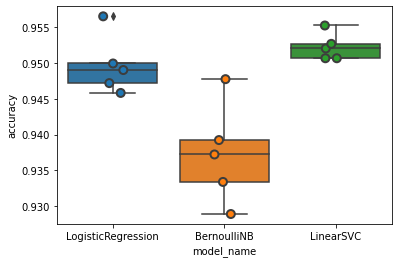

In [83]:
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

One fold of LogisticRegression, was the model that performed the best with this data. Even though in general LinearSVC is the one with the highest accuracy, approximately 95.5%. That is why we are going to choose it.

The Random Forest model was the model that besides to take the longest to run, it also is the one with worst performance.

### 5.4 Prediction of Label
Now that we selected Linear SVC as our statistical model, we are going to predict every label required and store the results of each measurement in a dataframe

In [ ]:
LinearSVC_results = pd.DataFrame(columns=['Label', 'Prep', 'Size', 'Accuracy', "Precision", "Recall", "F1score"])

models = [LinearSVC()] # Model chosen

# Stores the abstracts of the eight different combinations of parameters
combinations = [("InfoTheory", "Prep #1", "All Rows", x_train_1_all, x_test_1_all, trainLabelInfo, testLabelInfo),
                ("InfoTheory", "Prep #1", "1000 Rows", x_train_1_1000, x_test_1_1000, trainLabelInfo[:1000], testLabelInfo),
                ("InfoTheory", "Prep #2", "All Rows", x_train_2_all, x_test_2_all, trainLabelInfo, testLabelInfo),
                ("InfoTheory", "Prep #2", "1000 Rows", x_train_2_1000, x_test_2_1000, trainLabelInfo[:1000], testLabelInfo),
                ("CompVis", "Prep #1", "All Rows", x_train_1_all, x_test_1_all, trainLabelComp, testLabelComp),
                ("CompVis", "Prep #1", "1000 Rows", x_train_1_1000, x_test_1_1000, trainLabelComp[:1000], testLabelComp),
                ("CompVis", "Prep #2", "All Rows", x_train_2_all, x_test_2_all, trainLabelComp, testLabelComp),
                ("CompVis", "Prep #2", "1000 Rows", x_train_2_1000, x_test_2_1000, trainLabelComp[:1000], testLabelComp),
                ("Math", "Prep #1", "All Rows", x_train_1_all, x_test_1_all, trainLabelMath, testLabelMath),
                ("Math", "Prep #1", "1000 Rows", x_train_1_1000, x_test_1_1000, trainLabelMath[:1000], testLabelMath),
                ("Math", "Prep #2", "All Rows", x_train_2_all, x_test_2_all, trainLabelMath, testLabelMath),
                ("Math", "Prep #2", "1000 Rows", x_train_2_1000, x_test_2_1000, trainLabelMath[:1000], testLabelMath)]


cont = 0
for clf in models:
    for comb in combinations:
        print('\n')
        model_name = clf.__class__.__name__
        clf.fit(comb[3], comb[5]) # train the model
        y_predict=clf.predict(comb[4]) # Do the prediction
        
        # Store metric of the prediction with all rows
        LinearSVC_results.loc[cont, 'Label'] = comb[0]
        LinearSVC_results.loc[cont, 'Prep'] = comb[1]
        LinearSVC_results.loc[cont, 'Size'] = comb[2]
        LinearSVC_results.loc[cont, 'Accuracy'] = accuracy_score(comb[6],y_predict)
        LinearSVC_results.loc[cont, 'Precision'] = precision_score(comb[6],y_predict,average='macro')
        LinearSVC_results.loc[cont, 'Recall'] = recall_score(comb[6],y_predict,average='macro')
        LinearSVC_results.loc[cont, 'F1score'] = f1_score(comb[6],y_predict,average='macro')

        cont += 1
        

### 5.5 Results

In [143]:
LinearSVC_results['Model'] = "LinearSVC"

LinearSVC_results

,Label,Prep,Size,Accuracy,Precision,Recall,F1score,Model
0,InfoTheory,Prep #1,All Rows,0.95091,0.934559,0.897499,0.914591,LinearSVC
1,InfoTheory,Prep #1,1000 Rows,0.816445,0.908204,0.500553,0.450568,LinearSVC
2,InfoTheory,Prep #2,All Rows,0.954314,0.939599,0.904406,0.920725,LinearSVC
3,InfoTheory,Prep #2,1000 Rows,0.817156,0.908494,0.502489,0.454592,LinearSVC
4,CompVis,Prep #1,All Rows,0.968645,0.952971,0.880491,0.912615,LinearSVC
5,CompVis,Prep #1,1000 Rows,0.890639,0.44532,0.5,0.471078,LinearSVC
6,CompVis,Prep #2,All Rows,0.970881,0.96003,0.886026,0.91881,LinearSVC
7,CompVis,Prep #2,1000 Rows,0.890639,0.44532,0.5,0.471078,LinearSVC
8,Math,Prep #1,All Rows,0.869804,0.850728,0.834421,0.841826,LinearSVC
9,Math,Prep #1,1000 Rows,0.704086,0.678302,0.51492,0.448574,LinearSVC


## 6. RNN Model

### 6.1 Import Data
As we already preprocessed the data before, in this task we only have to tokenize the documents with a simple text split

In [86]:
import torch
from torchtext.legacy import data
from torchtext.legacy.data import TabularDataset

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

tokenize = lambda x: x.split() # As we already tokenize it before we just split 
TEXT = data.Field(sequential=True, tokenize = tokenize, lower=True)

LABEL = data.LabelField(dtype = torch.float, use_vocab=False, preprocessing=int)

Then we define the train fields

In [ ]:
train_fields = [("InfoTheory", LABEL),	("CompVis", LABEL),	("Math", LABEL), ("Abstract", TEXT)]

And finally, we import the data with all the rows

In [90]:


train_data_1_all, test_data_1_all = TabularDataset.splits(path="/content/drive/", train='train_prep_1.csv', test='test_prep_1.csv',
                                   format='csv',skip_header=True, fields=train_fields)

train_data_2_all, test_data_2_all = TabularDataset.splits(path="/content/drive/", train='train_prep_2.csv', test='test_prep_2.csv',
                                   format='csv',skip_header=True, fields=train_fields)

And the same data but just the first 1000 rows 

In [91]:
train_data_1_1000, test_data_1_1000 = TabularDataset.splits(path="/content/drive/", train='train_prep_1_1000.csv', test='test_prep_1.csv',
                                   format='csv',skip_header=True, fields=train_fields)

train_data_2_1000, test_data_2_1000 = TabularDataset.splits(path="/content/drive/", train='train_prep_2_1000.csv', test='test_prep_2.csv',
                                   format='csv',skip_header=True, fields=train_fields)

We can see how many examples are in each split by checking their length.


In [92]:
print(f'Number of training examples with preprocessing #1: {len(train_data_1_all)}')
print(f'Number of training examples with preprocessing #2: {len(train_data_2_all)}')
print(f'Number of testing examples with preprocessing #1: {len(test_data_1_all)}')
print(f'Number of testing examples with preprocessing #2: {len(test_data_2_all)}')

Number of training examples with preprocessing #1: 54731
Number of training examples with preprocessing #2: 54731
Number of testing examples with preprocessing #1: 19678
Number of testing examples with preprocessing #2: 19678


We can also check an example.

In [93]:
train_data_1_all

In [95]:
print(vars(train_data_1_all.examples[0]))

{'InfoTheory': 0, 'CompVis': 0, 'Math': 0, 'Abstract': ['nest', 'satisfi', 'special', 'case', 'satisfi', 'problem', 'claus', 'hierarch', 'structur', 'shown', 'solvabl', 'linear', 'time', 'assum', 'claus', 'repres', 'conveni', 'way']}


After that we create a vocabulary made out of Abstracts from all the rows of the traning dataset, and preprocessed with the method #1. But just with 10.000 tokens because it would take to much time to run with 52.234 words

In [107]:
MAX_VOCAB_SIZE = 10000 # All the vocabulary has 52.234 words but it will take to much time to run therefore we ch

TEXT.build_vocab(train_data_1_all, max_size = MAX_VOCAB_SIZE)

We build this vocabulary with this dataset, as it is the one with more words without looking at the test dataset. Because it is the one with more abstracs.

In [108]:
TEXT

In [109]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")

Unique tokens in TEXT vocabulary: 10002


After creating the vocabulary we can check what are the top 5 words after we perform the preprocessing method. 

In [110]:
print(TEXT.vocab.freqs.most_common(5))

[('use', 51026), ('network', 39237), ('algorithm', 39117), ('model', 36333), ('system', 34822)]


In [111]:
print(TEXT.vocab.itos[:5])
print(LABEL)

['<unk>', '<pad>', 'use', 'network', 'algorithm']


From the steps shown before, we can see that we built a vocabularu with 52.234 diferent words. And the most used word is `use`. Remember that we removed the stopswords




The final step of preparing the data is creating the iterators for each type of preprocessing and the size of the data set. That is why we build 4 different iterators:
  - 2 Different preprocessing methods
  - 2 Different sizes of datasets

### 6.2 Create Iterators

In [112]:
BATCH_SIZE = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Iterator for preprocessing method #1 and all the rows of the dataset
train_iterator_1_all, test_iterator_1_all = data.BucketIterator.splits(
    (train_data_1_all, test_data_1_all), 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.Abstract),
    sort_within_batch = False)

batch_1_all = next(train_iterator_1_all.__iter__())

# Iterator for preprocessing method #2 and all the rows of the dataset
train_iterator_2_all, test_iterator_2_all = data.BucketIterator.splits(
    (train_data_2_all, test_data_2_all), 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.Abstract),
    sort_within_batch = False)

batch_2_all = next(train_iterator_2_all.__iter__())

# Iterator for preprocessing method #1 and the first 1000 rows of the dataset
train_iterator_1_1000, test_iterator_1_1000 = data.BucketIterator.splits(
    (train_data_1_1000, test_data_1_1000), 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.Abstract),
    sort_within_batch = False)

batch_1_1000 = next(train_iterator_1_1000.__iter__())

# Iterator for preprocessing method #2 and the first 1000 rows of the dataset
train_iterator_2_1000, test_iterator_2_1000 = data.BucketIterator.splits(
    (train_data_2_1000, test_data_2_1000), 
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.Abstract),
    sort_within_batch = False)

batch_2_1000 = next(train_iterator_2_1000.__iter__())

### 6.3 Train RNN Model
The next stage is building the model that we'll eventually train and evaluate. 

In [113]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        
        assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(hidden.squeeze(0))

In [114]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)

In [115]:
model

RNN(
  (embedding): Embedding(10002, 100)
  (rnn): RNN(100, 256)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [116]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,092,105 trainable parameters


In [117]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [118]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [119]:
criterion = nn.BCEWithLogitsLoss()

In [120]:
model = model.to(device)
criterion = criterion.to(device)

In [121]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

#### 6.3.1 Auxiliary Infotheory Function

**Preprocessing Method #1 and All the Rows**

In [122]:
def train_InfoTheory_1_all(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()    
        predictions = model(batch_1_all.Abstract).squeeze(1)
        loss = criterion(predictions, batch_1_all.InfoTheory)
        acc = binary_accuracy(predictions, batch_1_all.InfoTheory)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Preprocessing Method #2 and All the Rows**

In [123]:
def train_InfoTheory_2_all(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()    
        predictions = model(batch_2_all.Abstract).squeeze(1)
        loss = criterion(predictions, batch_2_all.InfoTheory)
        acc = binary_accuracy(predictions, batch_2_all.InfoTheory)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Preprocessing Method #1 and First 1000 Rows**

In [124]:
def train_InfoTheory_1_1000(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()    
        predictions = model(batch_1_1000.Abstract).squeeze(1)
        loss = criterion(predictions, batch_1_1000.InfoTheory)
        acc = binary_accuracy(predictions, batch_1_1000.InfoTheory)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Preprocessing Method #2 and First 1000 Rows**

In [125]:
def train_InfoTheory_2_1000(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()    
        predictions = model(batch_2_1000.Abstract).squeeze(1)
        loss = criterion(predictions, batch_2_1000.InfoTheory)
        acc = binary_accuracy(predictions, batch_2_1000.InfoTheory)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#### 6.3.2 Auxiliary CompVis Function

**Preprocessing Method #1 and All the Rows**

In [126]:
def train_CompVis_1_all(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()    
        predictions = model(batch_1_all.Abstract).squeeze(1)
        loss = criterion(predictions, batch_1_all.CompVis)
        acc = binary_accuracy(predictions, batch_1_all.CompVis)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Preprocessing Method #2 and All the Rows**

In [127]:
def train_CompVis_2_all(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()    
        predictions = model(batch_2_all.Abstract).squeeze(1)
        loss = criterion(predictions, batch_2_all.CompVis)
        acc = binary_accuracy(predictions, batch_2_all.CompVis)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Preprocessing Method #1 and First 1000 Rows**

In [128]:
def train_CompVis_1_1000(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()    
        predictions = model(batch_1_1000.Abstract).squeeze(1)
        loss = criterion(predictions, batch_1_1000.CompVis)
        acc = binary_accuracy(predictions, batch_1_1000.CompVis)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Preprocessing Method #2 and First 1000 Rows**

In [129]:
def train_CompVis_2_1000(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()    
        predictions = model(batch_2_1000.Abstract).squeeze(1)
        loss = criterion(predictions, batch_2_1000.CompVis)
        acc = binary_accuracy(predictions, batch_2_1000.CompVis)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

#### 6.3.3 Auxiliary Math Function

**Preprocessing Method #1 and All the Rows**

In [130]:
def train_Math_1_all(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()    
        predictions = model(batch_1_all.Abstract).squeeze(1)
        loss = criterion(predictions, batch_1_all.Math)
        acc = binary_accuracy(predictions, batch_1_all.Math)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Preprocessing Method #2 and All the Rows**

In [131]:
def train_Math_2_all(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()    
        predictions = model(batch_2_all.Abstract).squeeze(1)
        loss = criterion(predictions, batch_2_all.Math)
        acc = binary_accuracy(predictions, batch_2_all.Math)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Preprocessing Method #1 and First 1000 Rows**

In [132]:
def train_Math_1_1000(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()    
        predictions = model(batch_1_1000.Abstract).squeeze(1)
        loss = criterion(predictions, batch_1_1000.Math)
        acc = binary_accuracy(predictions, batch_1_1000.Math)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

**Preprocessing Method #2 and First 1000 Rows**

In [133]:
def train_Math_2_1000(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()    
        predictions = model(batch_2_1000.Abstract).squeeze(1)
        loss = criterion(predictions, batch_2_1000.Math)
        acc = binary_accuracy(predictions, batch_2_1000.Math)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

### 6.4 Train Accuracy

First create a function to tell us how long an epoch takes to compare training times between models.

In [134]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We then train the model through multiple epochs, an epoch being a complete pass through all examples in the training and validation sets.

In [135]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss_Info_1_all, train_acc_Info_1_all = train_InfoTheory_1_all(model, train_iterator_1_all, optimizer, criterion)
    train_loss_Info_2_all, train_acc_Info_2_all = train_InfoTheory_2_all(model, train_iterator_2_all, optimizer, criterion)
    train_loss_Info_1_1000, train_acc_Info_1_1000 = train_InfoTheory_1_1000(model, train_iterator_1_1000, optimizer, criterion)
    train_loss_Info_2_1000, train_acc_Info_2_1000 = train_InfoTheory_2_1000(model, train_iterator_2_1000, optimizer, criterion)
    train_loss_Comp_1_all, train_acc_Comp_1_all = train_CompVis_1_all(model, train_iterator_1_all, optimizer, criterion)
    train_loss_Comp_2_all, train_acc_Comp_2_all = train_CompVis_2_all(model, train_iterator_2_all, optimizer, criterion)
    train_loss_Comp_1_1000, train_acc_Comp_1_1000 = train_CompVis_1_1000(model, train_iterator_1_1000, optimizer, criterion)
    train_loss_Comp_2_1000, train_acc_Comp_2_1000 = train_CompVis_2_1000(model, train_iterator_2_1000, optimizer, criterion)
    train_loss_Math_1_all, train_acc_Math_1_all = train_Math_1_all(model, train_iterator_1_all, optimizer, criterion)
    train_loss_Math_2_all, train_acc_Math_2_all = train_Math_2_all(model, train_iterator_2_all, optimizer, criterion)
    train_loss_Math_1_1000, train_acc_Math_1_1000 = train_Math_1_1000(model, train_iterator_1_1000, optimizer, criterion)
    train_loss_Math_2_1000, train_acc_Math_2_1000 = train_Math_2_1000(model, train_iterator_2_1000, optimizer, criterion)
  
    torch.save(model.state_dict(), 'RNN_model.pt')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain InfoTheory:')
    print(f'\t\tPrep #1 and All Rows Loss: {train_loss_Info_1_all:.3f} | Prep #1 and All Rows Acc: {train_acc_Info_1_all*100:.2f}%')
    print(f'\t\tPrep #2 and All Rows Loss: {train_loss_Info_2_all:.3f} | Prep #2 and All Rows Acc: {train_acc_Info_2_all*100:.2f}%')
    print(f'\t\tPrep #1 and 1000 Rows Loss: {train_loss_Info_1_1000:.3f} | Prep #1 and 1000 Rows Acc: {train_acc_Info_1_1000*100:.2f}%')
    print(f'\t\tPrep #2 and 1000 Rows Loss: {train_loss_Info_2_1000:.3f} | Prep #2 and 1000 Rows Acc: {train_acc_Info_2_1000*100:.2f}%')
    print(f'\tTrain CompVis:')
    print(f'\t\tPrep #1 and All Rows Loss: {train_loss_Comp_1_all:.3f} | Prep #1 and All Rows Acc: {train_acc_Comp_1_all*100:.2f}%')
    print(f'\t\tPrep #2 and All Rows Loss: {train_loss_Comp_2_all:.3f} | Prep #2 and All Rows Acc: {train_acc_Comp_2_all*100:.2f}%')
    print(f'\t\tPrep #1 and 1000 Rows Loss: {train_loss_Comp_1_1000:.3f} | Prep #1 and 1000 Rows Acc: {train_acc_Comp_1_1000*100:.2f}%')
    print(f'\t\tPrep #2 and 1000 Rows Loss: {train_loss_Comp_2_1000:.3f} | Prep #2 and 1000 Rows Acc: {train_acc_Comp_2_1000*100:.2f}%')
    print(f'\tTrain Math:')
    print(f'\t\tPrep #1 and All Rows Loss: {train_loss_Math_1_all:.3f} | Prep #1 and All Rows Acc: {train_acc_Math_1_all*100:.2f}%')
    print(f'\t\tPrep #2 and All Rows Loss: {train_loss_Math_2_all:.3f} | Prep #2 and All Rows Acc: {train_acc_Math_2_all*100:.2f}%')
    print(f'\t\tPrep #1 and 1000 Rows Loss: {train_loss_Math_1_1000:.3f} | Prep #1 and 1000 Rows Acc: {train_acc_Math_1_1000*100:.2f}%')
    print(f'\t\tPrep #2 and 1000 Rows Loss: {train_loss_Math_2_1000:.3f} | Prep #2 and 1000 Rows Acc: {train_acc_Math_2_1000*100:.2f}%')

Epoch: 01 | Epoch Time: 12m 0s
	Train InfoTheory:
		Prep #1 and All Rows Loss: 0.377 | Prep #1 and All Rows Acc: 87.50%
		Prep #2 and All Rows Loss: 0.379 | Prep #2 and All Rows Acc: 87.25%
		Prep #1 and 1000 Rows Loss: 0.120 | Prep #1 and 1000 Rows Acc: 100.00%
		Prep #2 and 1000 Rows Loss: 0.057 | Prep #2 and 1000 Rows Acc: 100.00%
	Train CompVis:
		Prep #1 and All Rows Loss: 0.008 | Prep #1 and All Rows Acc: 100.00%
		Prep #2 and All Rows Loss: 0.002 | Prep #2 and All Rows Acc: 100.00%
		Prep #1 and 1000 Rows Loss: 0.014 | Prep #1 and 1000 Rows Acc: 100.00%
		Prep #2 and 1000 Rows Loss: 0.001 | Prep #2 and 1000 Rows Acc: 100.00%
	Train Math:
		Prep #1 and All Rows Loss: 0.664 | Prep #1 and All Rows Acc: 62.50%
		Prep #2 and All Rows Loss: 0.632 | Prep #2 and All Rows Acc: 62.50%
		Prep #1 and 1000 Rows Loss: 0.217 | Prep #1 and 1000 Rows Acc: 100.00%
		Prep #2 and 1000 Rows Loss: 0.066 | Prep #2 and 1000 Rows Acc: 100.00%


### 6.5 Prediction of the Model

In [136]:
model.load_state_dict(torch.load('RNN_model.pt'))

<All keys matched successfully>

In [137]:
y_predict_1_all = []
y_predict_2_all = []
y_predict_1_1000 = []
y_predict_2_1000 = []
y_Info_1_all = []
y_Comp_1_all = []
y_Math_1_all = []
y_Info_2_all = []
y_Comp_2_all = []
y_Math_2_all = []
y_Info_1_1000 = []
y_Comp_1_1000 = []
y_Math_1_1000 = []
y_Info_2_1000 = []
y_Comp_2_1000 = []
y_Math_2_1000 = []

model.eval()
with torch.no_grad():
    for batch in test_iterator_1_all:
        predictions_1_all = model(batch.Abstract).squeeze(1)
        rounded_preds_1_all = torch.round(torch.sigmoid(predictions_1_all))
        y_predict_1_all += rounded_preds_1_all.tolist()
        y_Info_1_all += batch.InfoTheory.tolist()
        y_Comp_1_all += batch.CompVis.tolist()
        y_Math_1_all += batch.Math.tolist()
    
    for batch in test_iterator_2_all:
        predictions_2_all = model(batch.Abstract).squeeze(1)
        rounded_preds_2_all = torch.round(torch.sigmoid(predictions_2_all))
        y_predict_2_all += rounded_preds_2_all.tolist()
        y_Info_2_all += batch.InfoTheory.tolist()
        y_Comp_2_all += batch.CompVis.tolist()
        y_Math_2_all += batch.Math.tolist()

    for batch in test_iterator_1_1000:
        predictions_1_1000 = model(batch.Abstract).squeeze(1)
        rounded_preds_1_1000 = torch.round(torch.sigmoid(predictions_1_1000))
        y_predict_1_1000 += rounded_preds_1_1000.tolist()
        y_Info_1_1000 += batch.InfoTheory.tolist()
        y_Comp_1_1000 += batch.CompVis.tolist()
        y_Math_1_1000 += batch.Math.tolist()
    
    for batch in test_iterator_2_1000:
        predictions_2_1000 = model(batch.Abstract).squeeze(1)
        rounded_preds_2_1000 = torch.round(torch.sigmoid(predictions_2_1000))
        y_predict_2_1000 += rounded_preds_2_1000.tolist()
        y_Info_2_1000 += batch.InfoTheory.tolist()
        y_Comp_2_1000 += batch.CompVis.tolist()
        y_Math_2_1000 += batch.Math.tolist()

In [ ]:
combinations = [("InfoTheory", "Prep #1", "All Rows", np.asarray(y_Info_1_all), np.asarray(y_predict_1_all)),
                ("InfoTheory", "Prep #2", "All Rows", np.asarray(y_Info_2_all), np.asarray(y_predict_2_all)),
                ("InfoTheory", "Prep #1", "1000 Rows", np.asarray(y_Info_1_1000), np.asarray(y_predict_1_1000)),
                ("InfoTheory", "Prep #2", "1000 Rows", np.asarray(y_Info_2_1000), np.asarray(y_predict_2_1000)),
                ("CompVis", "Prep #1", "All Rows", np.asarray(y_Comp_1_all), np.asarray(y_predict_1_all)),
                ("CompVis", "Prep #2", "All Rows", np.asarray(y_Comp_2_all), np.asarray(y_predict_2_all)),
                ("CompVis", "Prep #1", "1000 Rows", np.asarray(y_Comp_1_1000), np.asarray(y_predict_1_1000)),
                ("CompVis", "Prep #2", "1000 Rows", np.asarray(y_Comp_2_1000), np.asarray(y_predict_2_1000)),
                ("Math", "Prep #1", "All Rows", np.asarray(y_Math_1_all), np.asarray(y_predict_1_all)),
                ("Math", "Prep #2", "All Rows", np.asarray(y_Math_2_all), np.asarray(y_predict_2_all)),
                ("Math", "Prep #1", "1000 Rows", np.asarray(y_Math_1_1000), np.asarray(y_predict_1_1000)),
                ("Math", "Prep #2", "1000 Rows", np.asarray(y_Math_2_1000), np.asarray(y_predict_2_1000))]

cont = 0
RNN_results = pd.DataFrame(columns=['Label', 'Prep', 'Size', 'Accuracy', "Precision", "Recall", "F1score"])
for i in combinations:
  # Store metric of the prediction with all rows
  RNN_results.loc[cont, 'Label'] = i[0]
  RNN_results.loc[cont, 'Prep'] = i[1]
  RNN_results.loc[cont, 'Size'] = i[2]
  RNN_results.loc[cont, 'Accuracy'] = accuracy_score(i[3],i[4])
  RNN_results.loc[cont, 'Precision'] = precision_score(i[3],i[4],average='macro')
  RNN_results.loc[cont, 'Recall'] = recall_score(i[3],i[4],average='macro')
  RNN_results.loc[cont, 'F1score'] = f1_score(i[3],i[4],average='macro')

  cont += 1

### 6.6 Results

In [144]:
RNN_results["Model"] = "RNN"

RNN_results

,Label,Prep,Size,Accuracy,Precision,Recall,F1score,Model
0,InfoTheory,Prep #1,All Rows,0.689349,0.501647,0.501772,0.50143,RNN
1,InfoTheory,Prep #2,All Rows,0.815987,0.408097,0.499844,0.449335,RNN
2,InfoTheory,Prep #1,1000 Rows,0.744,0.476594,0.491514,0.465236,RNN
3,InfoTheory,Prep #2,1000 Rows,0.787,0.3935,0.5,0.440403,RNN
4,CompVis,Prep #1,All Rows,0.724616,0.487661,0.479557,0.476655,RNN
5,CompVis,Prep #2,All Rows,0.890385,0.445306,0.499857,0.471007,RNN
6,CompVis,Prep #1,1000 Rows,0.853,0.506253,0.504379,0.503511,RNN
7,CompVis,Prep #2,1000 Rows,0.904,0.452,0.5,0.47479,RNN
8,Math,Prep #1,All Rows,0.618406,0.500208,0.500159,0.49367,RNN
9,Math,Prep #2,All Rows,0.698394,0.349286,0.499818,0.411209,RNN


## 7. Final Results

In [145]:
final_results = pd.concat([LinearSVC_results, RNN_results], ignore_index=True)
final_results

,Label,Prep,Size,Accuracy,Precision,Recall,F1score,Model
0,InfoTheory,Prep #1,All Rows,0.95091,0.934559,0.897499,0.914591,LinearSVC
1,InfoTheory,Prep #1,1000 Rows,0.816445,0.908204,0.500553,0.450568,LinearSVC
2,InfoTheory,Prep #2,All Rows,0.954314,0.939599,0.904406,0.920725,LinearSVC
3,InfoTheory,Prep #2,1000 Rows,0.817156,0.908494,0.502489,0.454592,LinearSVC
4,CompVis,Prep #1,All Rows,0.968645,0.952971,0.880491,0.912615,LinearSVC
5,CompVis,Prep #1,1000 Rows,0.890639,0.44532,0.5,0.471078,LinearSVC
6,CompVis,Prep #2,All Rows,0.970881,0.96003,0.886026,0.91881,LinearSVC
7,CompVis,Prep #2,1000 Rows,0.890639,0.44532,0.5,0.471078,LinearSVC
8,Math,Prep #1,All Rows,0.869804,0.850728,0.834421,0.841826,LinearSVC
9,Math,Prep #1,1000 Rows,0.704086,0.678302,0.51492,0.448574,LinearSVC


## 7. Visualization of Performance of Models
The visualization and analysis of performance of each model is in the PDF File submitted with this Jupiter Notebook

# Part 2: Topic Modelling

## 1. Import the library 

In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## 2. Documents
With the two preprocessing methods used in Task 1, we create our documents, by just splitting the words in lists `train_abstracts1` and `train_abstracts2`

In [181]:
train_abstracts1 = df_train_prep_1.Abstract.to_list()
train_abstracts2 = df_train_prep_2.Abstract.to_list()

In [182]:
tokenizer = RegexpTokenizer(r'\w+') # Tokenizer that matches every element of the corpus

for idx in range(len(train_abstracts1)):
    train_abstracts1[idx] = tokenizer.tokenize(train_abstracts1[idx])  # Split into words.

for idx in range(len(train_abstracts2)):
    train_abstracts2[idx] = tokenizer.tokenize(train_abstracts2[idx])  # Split into words.

## 3. Remove Common and Rare tokens
The main porpuse of this task is to remove `rare` tokens, those which does not apper in at least 20 documents, because they are not relevant in the corpus. 

Besides, we filter out the `common` words that occur in more than 50% of the documents, as we assume that are context words, and there are not relevant either.

The reason to remove those tokens is to better predict the topics of the corpus. Because pretty common words are going to be in all topics and rare tokens are just going to add some noise to the model

#### 3.1 train_abstracts1

In [186]:
# Create a dictionary representation of the documents.
dictionary_1 = Dictionary(train_abstracts1)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary_1.filter_extremes(no_below=20, no_above=0.5)

Finally, with that dictionary we build our corpus_1

In [187]:
# Bag-of-words representation of the documents.
corpus_1 = [dictionary_1.doc2bow(doc) for doc in train_abstracts1]

In [188]:
print('Number of unique tokens: %d' % len(dictionary_1))
print('Number of documents: %d' % len(corpus_1))

Number of unique tokens: 5938
Number of documents: 54731


#### 3.2 train_abstracts1

In [189]:
# Create a dictionary representation of the documents.
dictionary_2 = Dictionary(train_abstracts2)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary_2.filter_extremes(no_below=20, no_above=0.5)

Finally, with that dictionary we build our corpus_2

In [192]:
# Bag-of-words representation of the documents.
corpus_2 = [dictionary_2.doc2bow(doc) for doc in train_abstracts2]

In [193]:
print('Number of unique tokens: %d' % len(dictionary_2))
print('Number of documents: %d' % len(corpus_2))

Number of unique tokens: 9642
Number of documents: 54731


Again, by using two different preprocessing methods we find out that the number of tokens in each corpus is different. Even though the number of documents is the same.

In [194]:
print('dictionary_2 has ' + str(len(dictionary_2)-len(dictionary_1)) + ' tokens more than dictionary_1')
print('corpus_2 has ' + str(len(corpus_2)-len(corpus_1)) + ' documents more than corpus_1')

dictionary_2 has 3704 tokens more than dictionary_1
corpus_2 has 0 documents more than corpus_1


## 4. LDA Model
We are going to build 4 different models, changing 2 different parameters: `Preprocessing Method` and `Number of topics`, but the main parameters of the model will remain the same

### 4.1 Training Model

In [195]:
# Set training parameters.
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

After that we are going to train each model:

**Model 1:**
   - *Preprocessing:* Method #1 
   - *Number of topics:* 3 (Known three categories)

In [ ]:
NUM_TOPICS = 3

# Make a index to word dictionary.
temp = dictionary_1[0]  # This is only to "load" the dictionary.
id2word = dictionary_1.id2token

model_1 = LdaModel(
    corpus=corpus_1,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model_1{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model_1.save(outputfile)

**Model 2:**
   - *Preprocessing:* Method #1 
   - *Number of topics:* 20

In [ ]:
NUM_TOPICS = 20

# Make a index to word dictionary.
temp = dictionary_1[0]  # This is only to "load" the dictionary.
id2word = dictionary_1.id2token

model_2 = LdaModel(
    corpus=corpus_1,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model_2{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model_2.save(outputfile)

**Model 3:**
   - *Preprocessing:* Method #2
   - *Number of topics:* 3 (Known three categories)

In [ ]:
NUM_TOPICS = 3

# Make a index to word dictionary.
temp = dictionary_2[0]  # This is only to "load" the dictionary.
id2word = dictionary_2.id2token

model_3 = LdaModel(
    corpus=corpus_2,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model_3{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model_3.save(outputfile)

**Model 4:**
   - *Preprocessing:* Method #2
   - *Number of topics:* 20

In [ ]:
NUM_TOPICS = 20

# Make a index to word dictionary.
temp = dictionary_2[0]  # This is only to "load" the dictionary.
id2word = dictionary_2.id2token

model_4 = LdaModel(
    corpus=corpus_2,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=NUM_TOPICS,
    passes=passes,
    eval_every=eval_every
)
outputfile = f'model_4{NUM_TOPICS}.gensim'
print("Saving model in " + outputfile)
print("")
model_4.save(outputfile)

### 4.2 Exploration of the topics
Even though this part is going to be in a PDF, it is worth it to describe some insights found in the model as the visualizations are interactive. With them we can identify the most relevant words of each topic and the relevance of each word to each topic.

**Model 1:**
   - *Preprocessing:* Method #1 
   - *Number of topics:* 3 (Known three categories)

In [200]:
top_topics = model_1.top_topics(corpus_1) #, num_words=20)
model_1.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

lda_display = pyLDAvis.gensim.prepare(model_1, corpus_1, dictionary_1, sort_topics=False)
pyLDAvis.display(lda_display)

Average topic coherence: -0.2152.


In model 1 we used Preprocessing Method #1, therefore we could get rid of stopwords, that could appear in every document regardless of its topic. That is why it could be a better approach for these LDA models. 
By pointing the cursor over each circle we can identify the most relevant words per topic and try to guess what it is about.

It can be seen that each topic is pretty far from the other and they are not overlapping. It means that they are completly different. They also have almost the same size what means that there are almost the same amount of documents per topic, a pretty balanced dataset. 

From the beginning, we know that each abstract could be classified into three different categories: InfoTheory, CompVis, and Math. Now with a LDA model, we can check if they talk about these topics

In [208]:
for i,topic in model_1.show_topics(formatted=True, num_topics=3, num_words=5):
    print(str(i)+": "+ topic)

0: 0.016*"problem" + 0.015*"algorithm" + 0.011*"graph" + 0.011*"set" + 0.009*"gener"
1: 0.015*"network" + 0.012*"data" + 0.012*"model" + 0.011*"system" + 0.010*"base"
2: 0.014*"code" + 0.013*"channel" + 0.011*"optim" + 0.009*"propos" + 0.009*"algorithm"


**Model 2:**
   - *Preprocessing:* Method #1 
   - *Number of topics:* 10
   

In [201]:
top_topics = model_2.top_topics(corpus_1) #, num_words=20)
model_2.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

lda_display = pyLDAvis.gensim.prepare(model_2, corpus_1, dictionary_1, sort_topics=False)
pyLDAvis.display(lda_display)

Average topic coherence: -2.7750.


As model_1, in model_2 we also got rid of stop words. Something good for this model. In this case, we have too many topics close to each other and even overlapping one over the other one, meaning that these topics have a close relationship with each other. Another thing that can be observed is the size of the circles. They are much smaller than the topics from model_1. 

This is something that might be obvious because there are the same amount of documents but they have to be classified in 20 different topics instead of 3.

In [209]:
for i,topic in model_2.show_topics(formatted=True, num_topics=20, num_words=5):
    print(str(i)+": "+ topic)

0: 0.088*"quantum" + 0.037*"filter" + 0.036*"circuit" + 0.024*"classic" + 0.021*"comput"
1: 0.198*"graph" + 0.059*"tree" + 0.054*"edg" + 0.031*"path" + 0.029*"vertic"
2: 0.148*"user" + 0.064*"interfer" + 0.061*"scheme" + 0.031*"cell" + 0.029*"propos"
3: 0.026*"bound" + 0.018*"function" + 0.016*"gener" + 0.016*"set" + 0.013*"result"
4: 0.046*"imag" + 0.040*"learn" + 0.024*"featur" + 0.019*"method" + 0.019*"relay"
5: 0.077*"channel" + 0.037*"rate" + 0.026*"capac" + 0.024*"receiv" + 0.023*"inform"
6: 0.044*"word" + 0.038*"languag" + 0.030*"pattern" + 0.026*"text" + 0.018*"document"
7: 0.186*"network" + 0.050*"node" + 0.032*"commun" + 0.023*"mobil" + 0.017*"link"
8: 0.097*"data" + 0.024*"queri" + 0.015*"web" + 0.015*"memori" + 0.014*"kernel"
9: 0.064*"model" + 0.016*"distribut" + 0.013*"measur" + 0.012*"structur" + 0.012*"gener"
10: 0.031*"control" + 0.025*"energi" + 0.025*"system" + 0.021*"power" + 0.018*"time"
11: 0.170*"code" + 0.051*"decod" + 0.038*"error" + 0.021*"block" + 0.018*"bina

**Model 3:**
   - *Preprocessing:* Method #2
   - *Number of topics:* 3 (Known three categories)

In [202]:
top_topics = model_3.top_topics(corpus_2) #, num_words=20)
model_3.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

lda_display = pyLDAvis.gensim.prepare(model_3, corpus_2, dictionary_2, sort_topics=False)
pyLDAvis.display(lda_display)

Average topic coherence: -0.1938.


Different from Model 1, in this case, we did not remove the stop words, that is why we could see some words like `a` in topic 1. These stopwords could add some noise to the model as they can appear in any document of any topic. 

Even though we can observe again 3 different topics pretty far from each other without overlapping. Meaning that they are pretty different from each other. And in this case, topic 1 is approximately half of the size of topics 2 and 3. Meaning that it has half of the documents than the other 2 topics, this one is less important to this corpus

In [210]:
for i,topic in model_3.show_topics(formatted=True, num_topics=3, num_words=5):
    print(str(i)+": "+ topic)

0: 0.015*"channel" + 0.011*"code" + 0.010*"network" + 0.009*"rate" + 0.009*"scheme"
1: 0.014*"algorithm" + 0.013*"problem" + 0.008*"graph" + 0.008*"a" + 0.008*"be"
2: 0.011*"network" + 0.010*"a" + 0.009*"system" + 0.009*"data" + 0.008*"model"


**Model 4:**
   - *Preprocessing:* Method #2
   - *Number of topics:* 10

In [203]:
top_topics = model_4.top_topics(corpus_2) #, num_words=20)
model_4.num_topics

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / NUM_TOPICS
print('Average topic coherence: %.4f.' % avg_topic_coherence)

lda_display = pyLDAvis.gensim.prepare(model_4, corpus_2, dictionary_2, sort_topics=False)
pyLDAvis.display(lda_display)

Average topic coherence: -2.4898.


Like model 2, this model has 20 different topics that again seem to be related to each other because they are pretty close and overlapping one over the other. Even there is a topic (18) embedded in another topic (3), meaning that this is a subtopic of 3. But in this case, we did not remove  stops words from the corpus, and that is why you can see so many of them: 
- Topic 1: a
- Topic 4: From
- Topic 19: All words are have or have_been

In [211]:
for i,topic in model_4.show_topics(formatted=True, num_topics=20, num_words=5):
    print(str(i)+": "+ topic)

0: 0.053*"quantum" + 0.028*"security" + 0.023*"scheme" + 0.021*"attack" + 0.021*"key"
1: 0.037*"game" + 0.031*"source" + 0.027*"strategy" + 0.018*"rate" + 0.017*"gaussian"
2: 0.024*"system" + 0.023*"a" + 0.017*"it" + 0.015*"be" + 0.012*"paper"
3: 0.090*"graph" + 0.023*"vertex" + 0.023*"edge" + 0.020*"set" + 0.018*"problem"
4: 0.102*"data" + 0.061*"image" + 0.029*"feature" + 0.025*"object" + 0.020*"from"
5: 0.035*"user" + 0.020*"agent" + 0.017*"service" + 0.016*"information" + 0.015*"web"
6: 0.034*"function" + 0.032*"matrix" + 0.025*"linear" + 0.014*"space" + 0.013*"dimensional"
7: 0.045*"signal" + 0.029*"sensor" + 0.026*"system" + 0.025*"measurement" + 0.021*"noise"
8: 0.027*"language" + 0.020*"relay" + 0.020*"program" + 0.016*"word" + 0.011*"programming"
9: 0.024*"be" + 0.020*"can" + 0.018*"problem" + 0.016*"show" + 0.016*"number"
10: 0.055*"model" + 0.026*"distribution" + 0.018*"probability" + 0.016*"measure" + 0.015*"information"
11: 0.025*"time" + 0.020*"model" + 0.018*"dynamic" + 

Conclusion and deeper insights are in the PDF file submitted with this code